In [1]:
import numpy as np
from catemb.data import CatDataset
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

/opt/conda/envs/catemb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 来源统计

In [2]:
data_source_datafile_map = {"CLC-DB":"clc-db.npy",
                            "OSCAR":"oscar.npy",
                            "SadPhos-Library":"sadphos.npy",
                            "Tansoole":"tansoole.npy",
                            "Kraken":"kraken.npy",
                            "Literature":"nn_dioxide.npy"}
data_root_path = "../dataset/processed"
data_source_count_map = {}
for source in data_source_datafile_map:
    data_file = f"{data_root_path}/{data_source_datafile_map[source]}"
    dataset = np.load(data_file,allow_pickle=True)
    data_source_count_map[source] = len(dataset)

In [3]:
data_source_count_map

{'CLC-DB': 1689,
 'OSCAR': 3995,
 'SadPhos-Library': 890,
 'Tansoole': 13536,
 'Kraken': 1553,
 'Literature': 65}

## 去重后数据与算法生成的数据分布分析

In [4]:
dataset = CatDataset(root='../dataset/processed',name="lig_cat_dataset_xtbopt_new_62755",read_coord=True,save_smiles=True)
full_dataset = np.load("../dataset/processed/lig_cat_dataset_new.npy",allow_pickle=True)
smiles_with_opt_lst = [data.smiles for data in dataset]
mol_with_opt_lst = [Chem.MolFromSmiles(smi) for smi in smiles_with_opt_lst]
smiles_without_opt_lst = [data['smiles'] for data in full_dataset]
mol_without_opt_lst = [Chem.MolFromSmiles(smi) for smi in smiles_without_opt_lst]

In [5]:
cat_smi_metal_with_opt_map = {}
orig_lig_cat_smi_with_opt_lst = []
for smi, mol in zip(smiles_with_opt_lst, mol_with_opt_lst):
    dative_bonds = [bond for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DATIVE]
    #atoms_in_dative_bonds = [[bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol()] for bond in dative_bonds]
    if len(dative_bonds) > 0:
        metal_symbol = dative_bonds[0].GetEndAtom().GetSymbol()
        cat_smi_metal_with_opt_map[smi] = metal_symbol
    else:
        orig_lig_cat_smi_with_opt_lst.append(smi)
len(orig_lig_cat_smi_with_opt_lst),len(cat_smi_metal_with_opt_map)

(12618, 50137)

In [6]:
cat_smi_metal_without_opt_map = {}
orig_lig_cat_smi_without_opt_lst = []
for smi, mol in zip(smiles_without_opt_lst, mol_without_opt_lst):
    dative_bonds = [bond for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DATIVE]
    #atoms_in_dative_bonds = [[bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol()] for bond in dative_bonds]
    if len(dative_bonds) > 0:
        metal_symbol = dative_bonds[0].GetEndAtom().GetSymbol()
        cat_smi_metal_without_opt_map[smi] = metal_symbol
    else:
        orig_lig_cat_smi_without_opt_lst.append(smi)
len(orig_lig_cat_smi_without_opt_lst),len(cat_smi_metal_without_opt_map)

(12797, 53867)

## 配体类型数据分析

In [7]:
ligand_smarts_type_map = {'P-[#6,#7]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'P-[#6,#7]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'P-[#6,#7]~[#6]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'P-[#6,#7]~[#6]~[#6]~[#6]~[#6]-[C;H0]1=N[C,c][C,c]O1':"PHOX",
                          'O=[SX3]([*:4])[N]([*:3])[C]([H])([*:1])([*:2]).[PX3]([#6])([#6])':"SadPhos",
                          '[*][SX3](N([*])[CX4;!R]([*])C1=CC=CC=C1[PX3]([#6])([#6]))=O':"SadPhos",
                          '[*][CX4;!R]([CX4;!R][PX3]([#6])[#6])N([*])[S@@X3]([*])=O':"SadPhos",
                          '[*]C1([*])C2=C(C([CX4;!R]([*])N(*)[S@@X3]([*])=O)=CC=C2)OC3=C([PX3]([#6])([#6]))C=CC=C31':"SadPhos",
                          'PccCN([*])[S@@X3]([*])=O':"SadPhos",
                          'O1[C,c][C,c]N=[C]1~[#6]~[C]2=N[C,c][C,c]O2':"Box",
                          'O1[C,c][C,c]N=[C]1~[c]~[n]~[c]~[C]2=N[C,c][C,c]O2':"Box",
                          'O1[C,c][C,c]N=[C]1~[c]~[c]~[c]~[c]~[C]2=N[C,c][C,c]O2':"Box",
                          'O-c1ccccc1-C=[N,n]~[#6]~[#6]~[N,n]=C-c2ccccc2O':"Salen",
                          '[P]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          '[P]~[#6,c]~[#6,c]~[#6,c]~[#6,c]~[P]':"Bisphos",
                          'P-c1c2ccccc2ccc1-c3c(P)ccc4ccccc34':"Bisphos",
                          'PC12C3C4C5C1[Fe]25436789C%10C6C7C8C%109P':"Bisphos",
                          '[P;H0](-[#6])([-#6])-[#6]~[#6]~[P;H0](-[#6])-[#6]':"Bisphos",
                          "[P]-[N]-[c]~[c]~[c]~[c]-[N]-[P]":'Bisphos',
                          "[P]-[c]~[c]-[C]-[C]-[c]~[c]~[c]-[P]":'Bisphos',
                          "[P]-[c]~[c]~[A]~[c]~[c]-[P]":'Bisphos',
                          '[n,N,n+,N+]1~[c,C;H1]~[n,N,n+,N+]~[c,C]~[c,C]1':"NHC",
                          '[P;X3;H0;v3;!$(P=[O,S,N])](-[#6,c])(-[#6,c])-[#6,c]':"Monophos",
                          '[O-][N+]1(CCCCC1C=O)CCC[N+]2(C(C=O)CCCC2)[O-]':"N,N-Dioxide",
                          '[O-][N+]1(CCC[N+]2([O-])CCCC2C=O)CCCC1C=O':"N,N-Dioxide",
                          '[N][CX4][C](=[O])[O;H1]':"amino acid",
                          '[N][CX4][C](=[O])[O;H0-]':"amino acid",
                          '[P;X4;v5](=[O])([O;H1,H0-])([O,o])([O,o])':'Phos acid'
                          }
ligand_smarts_mol_map = {smarts:Chem.MolFromSmarts(smarts) for smarts in ligand_smarts_type_map}

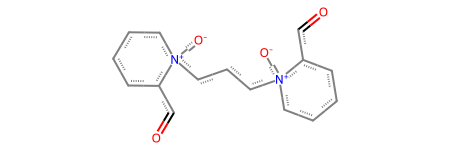

In [8]:
Chem.MolFromSmarts("[O-][N+]1(CCCCC1C=O)CCC[N+]2(C(C=O)CCCC2)[O-]")

In [9]:
orig_lig_cat_smi_without_opt_lst
lig_smi_type_map = {}
lig_smi_nometal_lst = []
for smi in orig_lig_cat_smi_without_opt_lst:
    mol = Chem.MolFromSmiles(smi)

    for smarts, type_ in ligand_smarts_type_map.items():
        scaffold_mol = ligand_smarts_mol_map[smarts]
        if mol.HasSubstructMatch(scaffold_mol):
            if not smi in lig_smi_type_map:
                lig_smi_type_map[smi] = [type_]
            else:
                if 'Bisphos' in lig_smi_type_map[smi] and type_ == 'Monophos':
                    continue
                lig_smi_type_map[smi].append(type_)
        
lig_type_smi_map = {}
for smi in lig_smi_type_map:
    for type_ in lig_smi_type_map[smi]:
        if not type_ in lig_type_smi_map:
            lig_type_smi_map[type_] = [smi]
        else:
            lig_type_smi_map[type_].append(smi)
lig_type_count_map = {}
for type_ in lig_type_smi_map:
    lig_type_count_map[type_] = len(lig_type_smi_map[type_])


In [10]:
lig_type_count_map

{'Monophos': 2333,
 'Bisphos': 291,
 'SadPhos': 326,
 'Phos acid': 129,
 'amino acid': 1649,
 'NHC': 113,
 'Salen': 14,
 'PHOX': 100,
 'Box': 253,
 'N,N-Dioxide': 65}

In [11]:
metal_lst = list(cat_smi_metal_without_opt_map.values())
metal_ct_lst = sorted([[metal, metal_lst.count(metal)] for metal in set(metal_lst)], key=lambda x: x[1], reverse=True)
print("\n".join([",".join([item[0],str(item[1])]) for item in metal_ct_lst]))

Pd,13866
Ni,12195
Cu,7916
Rh,7432
Ru,5016
Au,2755
Ir,881
Fe,862
Zn,622
Co,482
Mn,304
Sn,253
Ag,100
Mg,65
Tm,65
Er,65
Ho,65
Pr,65
Sm,65
Yb,65
Nd,65
Y,65
Tb,65
Lu,65
Gd,65
Ce,65
La,65
Ba,65
Eu,65
Dy,65
Sc,65
Ti,13


### Plot

In [12]:
from catemb import CatEmb
from catemb.utils import set_seed
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from copy import deepcopy
set_seed(42)
lig_type_color_map = {'Monophos': 'lightcoral',
 'Bisphos': 'saddlebrown',
 'SadPhos': 'darkorange',
 'PHOX': 'lightgreen',
 'NHC': 'green',
 'amino acid': 'navy',
 'Salen': 'deepskyblue',
 'Box': 'pink',
 'Phos acid': 'orchid',
 'N,N-Dioxide':'gray'}
model_path = '../code/save_model/260202-0640h_equif_plat_lr1e-4_decay_step5_temp0.1_EBM_dot_prod_xtbopt62755_equif_first_dim32_cl_kl_e_111_ln'
catemb_calc = CatEmb(model_path=model_path, device='cpu')

In [13]:
sel_lig_smi_lst = []
sel_lig_type_lst = []
for smi in lig_smi_type_map:
    type_ = lig_smi_type_map[smi][0]
    sel_lig_smi_lst.append(smi)
    sel_lig_type_lst.append(type_)

In [14]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
lig_desc = catemb_calc.gen_desc(sel_lig_smi_lst)
lig_tsne = tsne.fit_transform(lig_desc)

In [15]:
X = deepcopy(lig_tsne)
lig_type_x_map = {}
lig_type_idx_map = {}
for idx in range(len(sel_lig_smi_lst)):
    x = X[idx]
    smi = sel_lig_smi_lst[idx]
    type_ = lig_smi_type_map[smi][0]
    if not type_ in lig_type_x_map:
        lig_type_x_map[type_] = [x]
        lig_type_idx_map[type_] = [idx]
    else:
        lig_type_x_map[type_].append(x)
        lig_type_idx_map[type_].append(idx)
lig_type_x_map = {type_: np.array(x_lst) for type_, x_lst in lig_type_x_map.items()}

In [22]:
for _x, _idx in zip(lig_type_x_map['Salen'],lig_type_idx_map['Salen']):
    print(_x, sel_lig_smi_lst[_idx])

[ 32.904346 -35.624077] CC(C)(C)c1ccc(O)c(C=N[C@H]2CCCC[C@@H]2N=Cc2cc(C(C)(C)C)ccc2O)c1
[ 32.9644  -36.26895] Cc1cc(C(C)(C)C)cc(C=N[C@H]2CCCC[C@@H]2N=Cc2cc(C(C)(C)C)cc(C)c2O)c1O
[ 32.9077   -35.631763] CC(C)(C)c1ccc(O)c(C=N[C@@H]2CCCC[C@H]2N=Cc2cc(C(C)(C)C)ccc2O)c1
[ 32.96952  -36.277973] Cc1cc(C(C)(C)C)cc(C=N[C@@H]2CCCC[C@H]2N=Cc2cc(C(C)(C)C)cc(C)c2O)c1O
[ 33.54571 -36.69495] CC(C)(C)c1cc(C=N[C@@H]2CCCC[C@H]2N=Cc2cc(C(C)(C)C)cc(C(C)(C)C)c2O)c(O)c(C(C)(C)C)c1
[ 33.542267 -36.688835] CC(C)(C)c1cc(C=N[C@H]2CCCC[C@@H]2N=Cc2cc(C(C)(C)C)cc(C(C)(C)C)c2O)c(O)c(C(C)(C)C)c1
[ 33.576008 -36.804733] CC(C)(C)c1cc2c(c(C(C)(C)C)c1)[O][Al]([Cl])[O]c1c(cc(C(C)(C)C)cc1C(C)(C)C)C=N[C@H]1CCCC[C@@H]1N=C2
[-28.158     -4.674528] Oc1ccccc1C=NCCN=Cc1ccccc1O
[-30.513287   -3.2394478] Oc1ccc(O)c(C=NCCN=Cc2cc(O)ccc2O)c1
[-28.108871   -4.7282195] Oc1ccccc1C=Nc1ccccc1N=Cc1ccccc1O
[ 33.804325 -36.896473] CC(C)(C)c1cc(C=NC(C)(C)C(C)(C)N=Cc2cc(C(C)(C)C)cc(C(C)(C)C)c2O)c(O)c(C(C)(C)C)c1
[ 33.558636 -36.711132] CC(C)(

In [107]:
for type_ in lig_type_x_map:
    idx_lst = lig_type_idx_map[type_]
    x_lst = lig_type_x_map[type_]
    x_ave = np.mean(x_lst, axis=0)
    _x_cent = (x_lst.min(0)[0]+x_lst.max(0)[0])/2
    _y_cent = (x_lst.min(0)[1]+x_lst.max(0)[1])/2
    x_center = np.array([_x_cent,_y_cent])
    center_idx = np.linalg.norm(x_lst - x_center,axis=1).argmin()
    #x_center = x_lst[center_idx]
    center_smiles = sel_lig_smi_lst[idx_lst[center_idx]]
    print(type_, x_center,f"x from {x_lst.min(0)[0]:.1f} to {x_lst.max(0)[0]:.1f}",f"y from {x_lst.min(0)[1]:.1f} to {x_lst.max(0)[1]:.1f}",center_smiles)

Monophos [ 14.208797 -19.737625] x from -53.9 to 82.4 y from -76.3 to 36.8 CC(C)(C)c1cc(C(C)(C)C)c(-c2cc(-c3c(C(C)(C)C)cc(C(C)(C)C)cc3C(C)(C)C)cc(P(C3CCCC3)C3CCCC3)c2)c(C(C)(C)C)c1
Bisphos [ 22.950369 -23.184834] x from -27.2 to 73.1 y from -75.5 to 29.1 COc1c(C(C)(C)C)cc(P(c2cc(C(C)(C)C)c(OC)c(C(C)(C)C)c2)c2ccc3ccccc3c2-c2c(P(c3cc(C(C)(C)C)c(OC)c(C(C)(C)C)c3)c3cc(C(C)(C)C)c(OC)c(C(C)(C)C)c3)ccc3ccccc23)cc1C(C)(C)C
SadPhos [ 49.674744 -24.275236] x from 13.3 to 86.0 y from -67.0 to 18.4 COc1ccc([C@H](c2cc(OC)c(OC)cc2P(c2ccccc2)c2ccccc2)N(C)[S@](=O)C(C)(C)C)cc1
Phos acid [-11.143889 -43.29231 ] x from -29.5 to 7.2 y from -78.6 to -8.0 COc1cccc(OC)c1-c1cc2ccccc2c2c1OP(=O)(O)Oc1c(-c3c(OC)cccc3OC)cc3ccccc3c1-2
amino acid [-30.553658  19.068232] x from -78.5 to 17.4 y from -33.0 to 71.1 O=C(N[C@@H](Cc1ccccc1F)C(=O)O)OCc1ccccc1
NHC [-17.666498   -2.2508907] x from -77.8 to 42.5 y from -67.4 to 62.9 Oc1ccc2c(-n3ccnc3)cccc2c1-c1c(O)ccc2c(-n3ccnc3)cccc12
Salen [1.6455193 0.5499363] x from -30.5

In [108]:
lig_type_idx_map.keys()

dict_keys(['Monophos', 'Bisphos', 'SadPhos', 'Phos acid', 'amino acid', 'NHC', 'Salen', 'PHOX', 'Box', 'N,N-Dioxide'])

In [92]:
phos_acid = [sel_lig_smi_lst[lig_type_idx_map['N,N-Dioxide'][idx]] for idx in range(len(lig_type_idx_map['N,N-Dioxide']))]
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in phos_acid],molsPerRow=4,subImgSize=(200,200),legends=[smi for smi in phos_acid],useSVG=True)

86.01818 -78.48043 71.11848 -78.55964


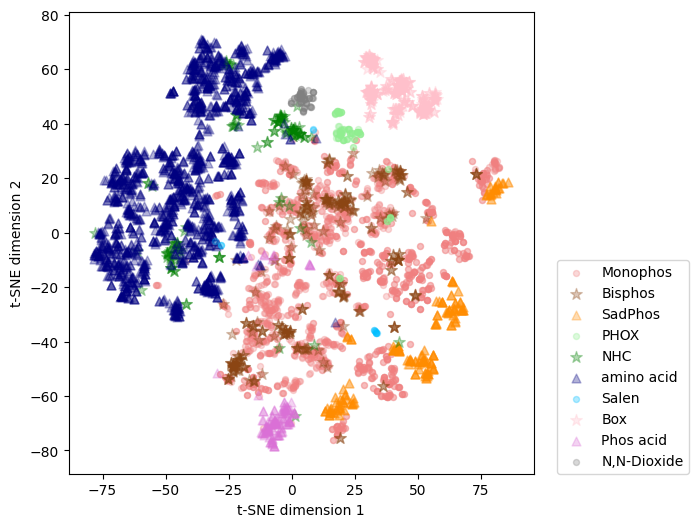

In [109]:
ct = 0
maker_type = ['.','*',"^"]
maker_size = [75,75,40]
lig_type_ave_x_map = {}
plt.figure(figsize=(6,6))
x_max = 0
x_min = 0
y_max = 0
y_min = 0
for idx,type_ in enumerate(lig_type_color_map.keys()):
    x_lst = lig_type_x_map[type_]
    
    plt.scatter(x_lst[:,0],x_lst[:,1],color=lig_type_color_map[type_],label=type_,alpha=0.3,marker=maker_type[idx%3],s=maker_size[idx%3])
    ave_0 = np.mean(x_lst[:,0])
    ave_1 = np.mean(x_lst[:,1])
    #plt.scatter(ave_0,ave_1,color=lig_type_color_map[type_],label=type_+' ave',s=maker_size[idx%2],marker=maker_type[idx%2],edgecolors='gray')
    lig_type_ave_x_map[type_] = np.array([ave_0,ave_1])
    x_max = max(x_max,np.max(x_lst[:,0]))
    x_min = min(x_min,np.min(x_lst[:,0]))
    y_max = max(y_max,np.max(x_lst[:,1]))
    y_min = min(y_min,np.min(x_lst[:,1]))
print(x_max,x_min,y_max,y_min)

plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.xlim([x_min-10,x_max+10])
plt.ylim([y_min-10,y_max+10])
plt.legend(loc=(1.05,0))

In [110]:
label_fontsize = 15
tick_fontsize = 14

86.01818 -78.48043 71.11848 -78.55964


(-88.55963897705078, 81.11847686767578)

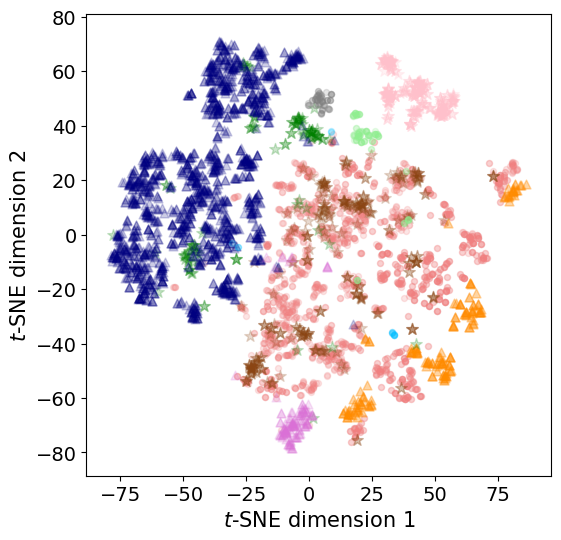

In [111]:
ct = 0
maker_type = ['.','*',"^"]
maker_size = [75,75,40]
lig_type_ave_x_map = {}
plt.figure(figsize=(6,6))
x_max = 0
x_min = 0
y_max = 0
y_min = 0
for idx,type_ in enumerate(lig_type_color_map.keys()):
    x_lst = lig_type_x_map[type_]
    
    plt.scatter(x_lst[:,0],x_lst[:,1],color=lig_type_color_map[type_],label=type_,alpha=0.2,marker=maker_type[idx%3],s=maker_size[idx%3])
    ave_0 = np.mean(x_lst[:,0])
    ave_1 = np.mean(x_lst[:,1])
    #plt.scatter(ave_0,ave_1,color=lig_type_color_map[type_],label=type_+' ave',s=maker_size[idx%2],marker=maker_type[idx%2],edgecolors='gray')
    lig_type_ave_x_map[type_] = np.array([ave_0,ave_1])
    x_max = max(x_max,np.max(x_lst[:,0]))
    x_min = min(x_min,np.min(x_lst[:,0]))
    y_max = max(y_max,np.max(x_lst[:,1]))
    y_min = min(y_min,np.min(x_lst[:,1]))
print(x_max,x_min,y_max,y_min)

plt.xlabel("$\tt$-SNE dimension 1",fontsize=label_fontsize)
plt.ylabel("$\tt$-SNE dimension 2",fontsize=label_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.xlim([x_min-10,x_max+10])
plt.ylim([y_min-10,y_max+10])
#plt.legend(loc=(1.05,0))

Monophos 40.63 %, sample num: 1941
Bisphos 27.34 %, sample num: 283
SadPhos 10.22 %, sample num: 316
PHOX 3.43 %, sample num: 100
NHC 34.19 %, sample num: 113
amino acid 30.36 %, sample num: 1617
Salen 8.09 %, sample num: 14
Box 1.87 %, sample num: 253
Phos acid 6.93 %, sample num: 125
N,N-Dioxide 0.20 %, sample num: 65


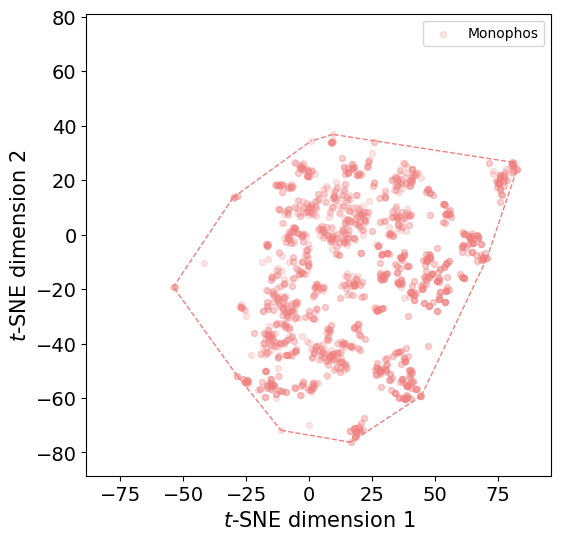

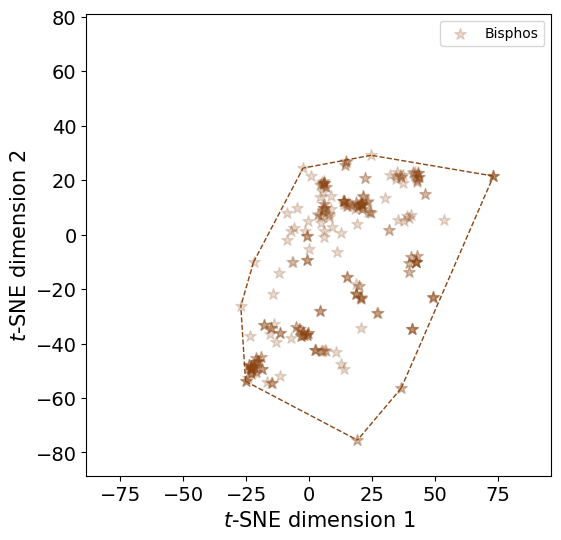

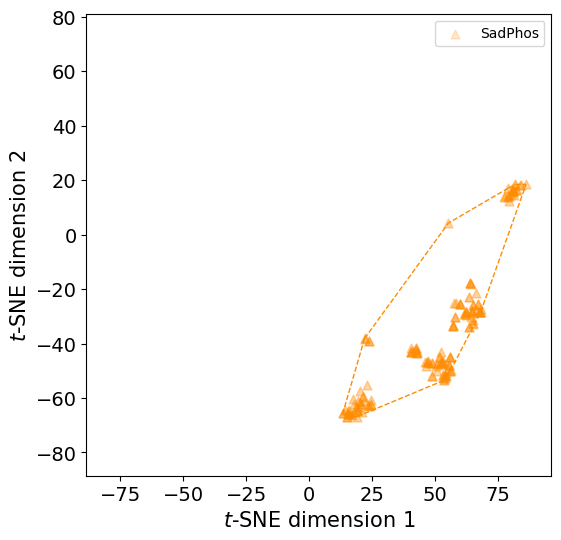

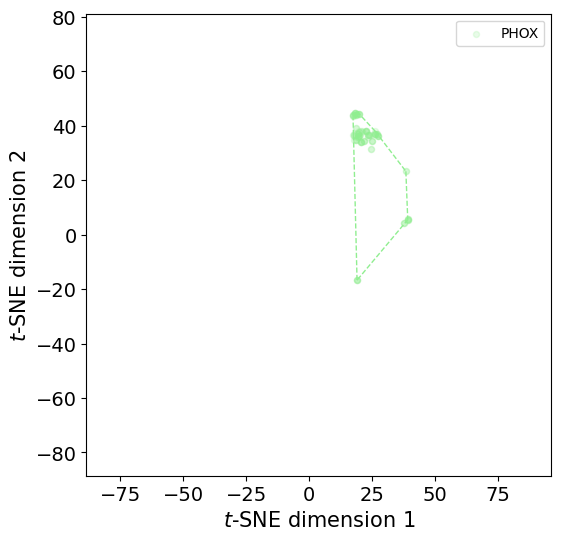

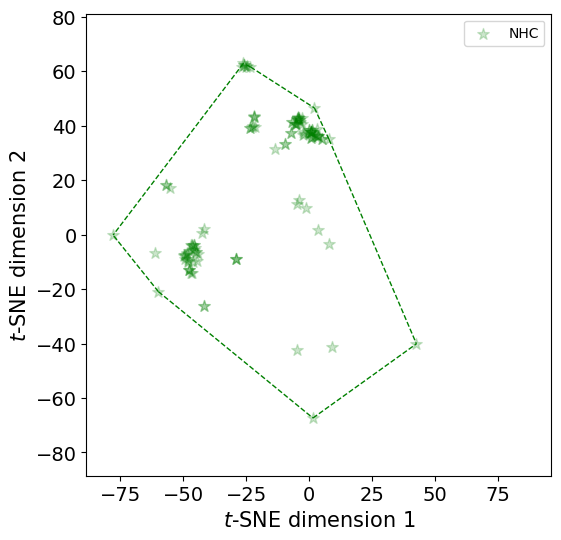

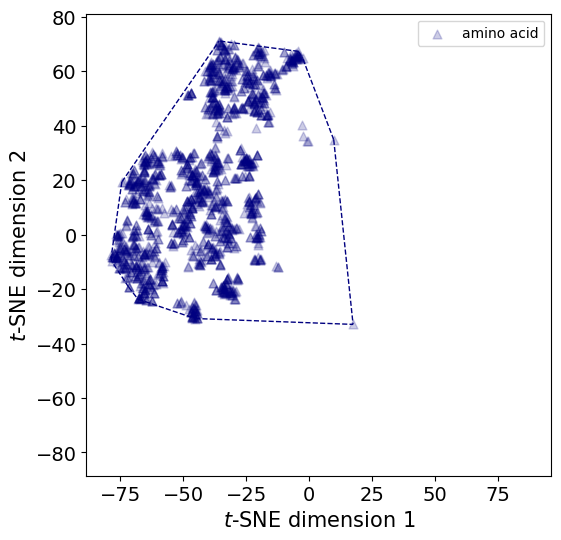

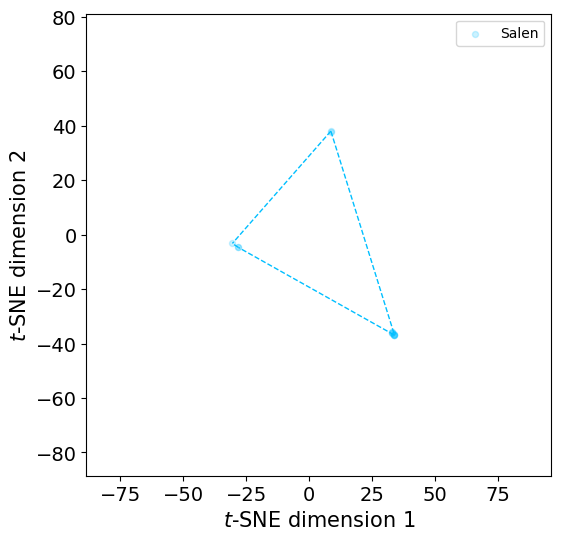

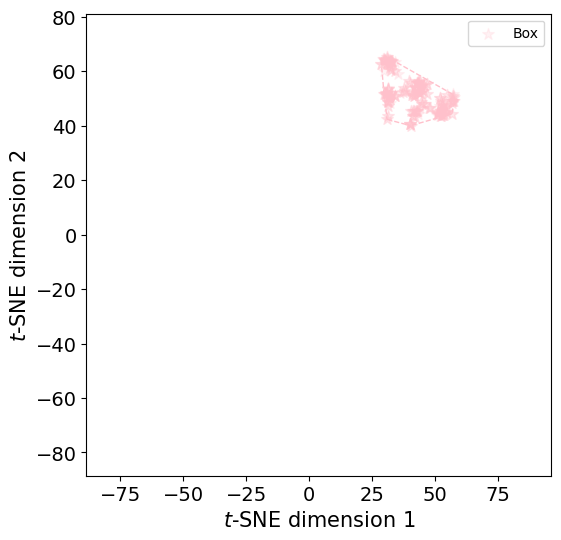

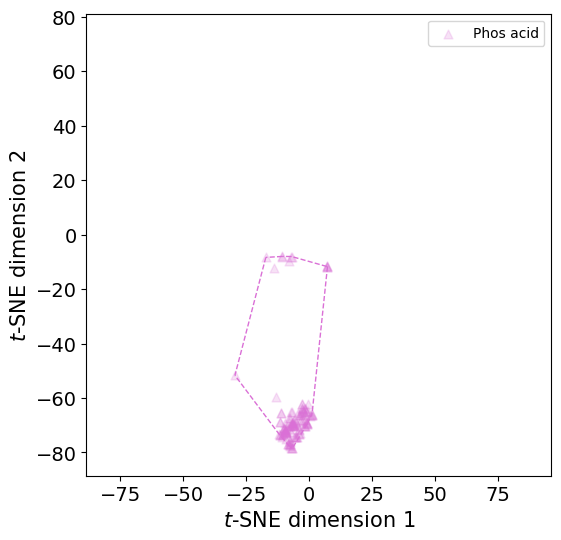

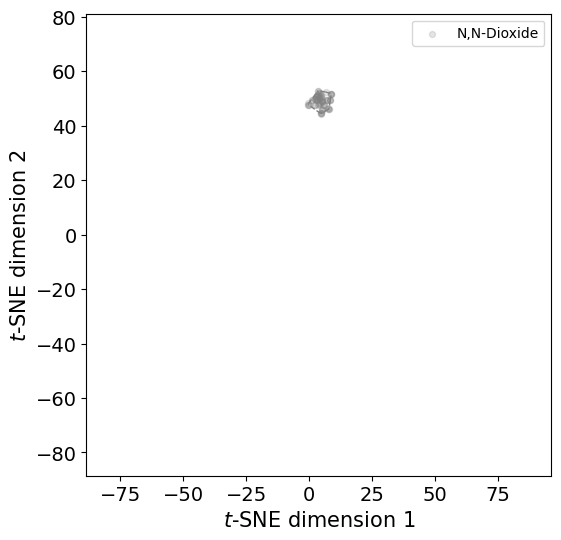

In [112]:
ct = 0
maker_type = ['.','*',"^"]
maker_size = [75,75,40]
lig_type_ave_x_map = {}
whole_space_area = (x_max-x_min)*(y_max-y_min)
for idx,type_ in enumerate(lig_type_color_map.keys()):
    plt.figure(figsize=(6,6))
    x_lst = lig_type_x_map[type_]
    hull = ConvexHull(x_lst)
    hull_area = hull.volume
    for simplex in hull.simplices:
        plt.plot(x_lst[simplex, 0], x_lst[simplex, 1],  '--', color=lig_type_color_map[type_], linewidth=1, label='Convex Hull' if simplex is hull.simplices[0] else "")
    plt.scatter(x_lst[:,0],x_lst[:,1],color=lig_type_color_map[type_],label=type_,alpha=0.2,marker=maker_type[idx%3],s=maker_size[idx%3])
    ave_0 = np.mean(x_lst[:,0])
    ave_1 = np.mean(x_lst[:,1])
    #plt.scatter(ave_0,ave_1,color=lig_type_color_map[type_],label=type_+' ave',s=maker_size[idx%2],marker=maker_type[idx%2],edgecolors='gray')
    lig_type_ave_x_map[type_] = np.array([ave_0,ave_1])
    plt.xlabel("$\tt$-SNE dimension 1",fontsize=label_fontsize)
    plt.ylabel("$\tt$-SNE dimension 2",fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.xlim([x_min-10,x_max+10])
    plt.ylim([y_min-10,y_max+10])
    plt.legend()
    print(type_,f"{hull_area/whole_space_area*100:.2f} %, sample num: {len(x_lst)}")

In [39]:
lig_type_x_map

{'Monophos': array([[-15.499983, -54.403503],
        [-28.55649 , -51.920578],
        [-24.74596 , -54.203842],
        ...,
        [  9.141772,  33.774323],
        [ 19.186115, -15.341386],
        [-12.63927 , -39.7495  ]], shape=(1941, 2), dtype=float32),
 'Bisphos': array([[-23.048405  , -48.871147  ],
        [-23.066143  , -48.850517  ],
        [-20.533281  , -46.293293  ],
        [-18.752768  , -49.397804  ],
        [-24.018309  , -47.913773  ],
        [-23.08956   , -48.34285   ],
        [-23.120995  , -49.36901   ],
        [-23.216173  , -50.99853   ],
        [-25.290466  , -53.785954  ],
        [-23.205936  , -50.975475  ],
        [-14.69513   , -54.442883  ],
        [-14.798184  , -54.41819   ],
        [-21.878746  , -48.63576   ],
        [-21.230566  , -45.269012  ],
        [-24.02551   , -47.898598  ],
        [-23.137114  , -49.38974   ],
        [-23.153475  , -48.29297   ],
        [-25.22272   , -53.70525   ],
        [-21.86297   , -48.625458  ],
    

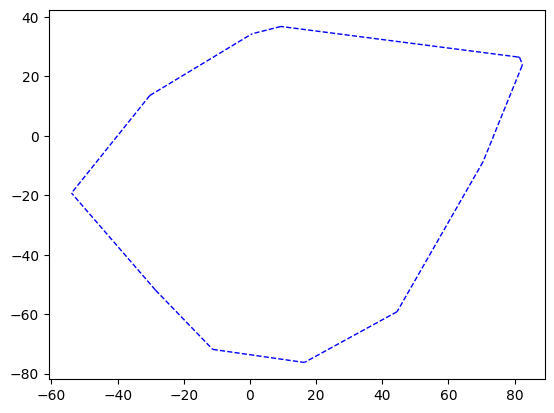

In [49]:
hull = ConvexHull(lig_type_x_map['Monophos'])
hull_area = hull.volume
for simplex in hull.simplices:
    plt.plot(lig_type_x_map['Monophos'][simplex, 0], lig_type_x_map['Monophos'][simplex, 1], 'b--', linewidth=1, label='Convex Hull' if simplex is hull.simplices[0] else "")

In [48]:
hull_area

10004.696781245257